# Projet Traitement des données distribuées
## *Etudiants : Simon Aubeneau, Flora Ziadi*

In [4]:
# commande à utiliser sur nos machines
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [9]:
# commande à utiliser sur le serveur de l'école
# afficher l'application id pour voir combien de ressources on consomme
sc.applicationId

# aller sur http://35.180.27.218:8088/cluster/apps/RUNNING 
# pour voir notre consommation

'local-1525784716880'

In [10]:
#afficher configuration du système
spark  #Lancement de spark au demarrage!

In [11]:
# supprimer la base de données
!hadoop fs -rm -r dataSample/data_songs.csv  #Ajout des données dans HDFS (a faire une fois)

# charger fichiers vers hadoop 
!hadoop fs -put ../dataSample/data_songs.csv dataSample/data_songs.csv  #Ajout des données dans HDFS (a faire une fois)

# récupérer fichers depuis hadoop
!hadoop fs -get /user/hadoop/file localfile

In [12]:
# afficher liste fichiers dispos sur le système hadoop
#On verifie que le fichier est bien dans hdfs
!hadoop fs -ls dataSample

In [5]:
# import des librairies python
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

# librairie spark sql
from pyspark.sql.functions import col
from pyspark.sql.functions import expr

# librairie spark ml
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [14]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Partie 1 : Analyse exploratoire de la base de données

##   1. Présentation des données 

Pour ce projet, nous avons utilisé le jeu de données suivant : https://www.kaggle.com/geomack/spotifyclassification/data

Ce jeu de données contient 2017 chansons avec des attributs de l'API Spotify. 

Un utilisateur a attribué la note de « 1 » s’il aime la chanson et « 0 » s’il n’aime pas la chanson. L’objectif est de construire un classificateur qui pourrait prédire si l'utilisateur aime ou non une chanson.

La base est composée de 16 colonnes : 13 sont des attributs de chanson, une colonne pour le nom de la chanson, une pour l'artiste, et une colonne cible ("target") qui est l'étiquette avec la note attribuée à la chanson.

Les 13 attributs de la piste sont les suivants : l'acoustique, la danceabilité, la durée, l'énergie, l'instrumentalité, la touche, la vivacité, le volume, le mode, la faculté d'expression, le tempo, la signature temporelle, la valence.

Vous trouverez une définition détaillée de chaque variable au lien suivant : https://developer.spotify.com/web-api/get-audio-features/  

In [6]:
%%time
# import de la base de données au format spark
#sdf = spark.read.csv('dataSample/data_songs.csv', header=True, sep=",", inferSchema=True)
sdf = spark.read.csv('data_songs.csv', header=True, sep=",", inferSchema=True)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 12.8 s


In [7]:
len(sdf.dtypes)  # 17 colonnes

17

In [8]:
sdf.count() # 2017 lignes 

2017

In [9]:
# liste des variables présente dans la table
sdf.printSchema() 

root
 |-- _c0: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- song_title: string (nullable = true)
 |-- artist: string (nullable = true)



In [10]:
# visualiser un extrait du dataframe
sdf.show()

+---+------------+------------+-----------+------+----------------+---+--------+--------+----+-----------+-------+--------------+-------+------+--------------------+------------------+
|_c0|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness|mode|speechiness|  tempo|time_signature|valence|target|          song_title|            artist|
+---+------------+------------+-----------+------+----------------+---+--------+--------+----+-----------+-------+--------------+-------+------+--------------------+------------------+
|  0|      0.0102|       0.833|     204600| 0.434|          0.0219|  2|   0.165|  -8.795|   1|      0.431|150.062|           4.0|  0.286|     1|            Mask Off|            Future|
|  1|       0.199|       0.743|     326933| 0.359|         0.00611|  1|   0.137| -10.401|   1|     0.0794|160.083|           4.0|  0.588|     1|             Redbone|  Childish Gambino|
|  2|      0.0344|       0.838|     185707| 0.412|         2.34E-4|  2|   0

In [11]:
# variable explicatives numériques
var_num  = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']

# afficher statistiques descriptives sur les variables numériques (dans des tableaux différents)
for v in var_num:
    sdf.describe(v).show()

+-------+-------------------+
|summary|       acousticness|
+-------+-------------------+
|  count|               2017|
|   mean|0.18759003442241004|
| stddev|0.25998925978484005|
|    min|            2.84E-6|
|    max|              0.995|
+-------+-------------------+

+-------+------------------+
|summary|      danceability|
+-------+------------------+
|  count|              2017|
|   mean|0.6184219137332657|
| stddev|0.1610289674217501|
|    min|             0.122|
|    max|             0.984|
+-------+------------------+

+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|              2017|
|   mean|246306.19732275658|
| stddev|  81981.8142190362|
|    min|             16042|
|    max|           1004627|
+-------+------------------+

+-------+-------------------+
|summary|             energy|
+-------+-------------------+
|  count|               2017|
|   mean| 0.6815771442736742|
| stddev|0.21027300892392292|
|    min|             0.0

## 2. Les goûts du testeur  

Dans cette partie nous essayé de comprendre les goûts du testeurs.

In [12]:
# variable à expliquer :
sdf.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1020|
|     0|  997|
+------+-----+



Le testeur aime 1020 chansons et n'aime pas 997 chansons.

### Quels sont les artistes les plus representés dans la liste? Quels sont les artistes préférés par le testeur?

In [13]:
# Les chanteurs les plus représentés dans la liste sont :
a = sdf.groupBy('artist').count()
b = sdf.groupBy('artist').sum('target')
# on fait un join 
c=a.join(b,on=['artist'])
# on renome les colonnes
d = c.withColumnRenamed("sum(target)","sum_target").withColumnRenamed("count","nb_occ")
# on crée une nouvelle variable qui correspond à la probabilité que le testeur aime l'artiste
e = d.withColumn("ratio",expr('sum_target/nb_occ'))
# on trie la table en fonction du nombre de fois que l'artiste apparait
sdf_artist = e.sort('count', ascending=False)
sdf_artist.show(20)

+----------------+------+----------+------------------+
|          artist|nb_occ|sum_target|             ratio|
+----------------+------+----------+------------------+
|           Drake|    16|        13|            0.8125|
|       Rick Ross|    13|         4|0.3076923076923077|
|      Disclosure|    12|        12|               1.0|
|   WALK THE MOON|    10|         0|               0.0|
| Backstreet Boys|    10|         0|               0.0|
|          FIDLAR|     9|         9|               1.0|
| Crystal Castles|     9|         9|               1.0|
|      Kanye West|     8|         8|               1.0|
|          Future|     8|         6|              0.75|
|     Demi Lovato|     8|         0|               0.0|
| Michael Jackson|     8|         0|               0.0|
|        Skrillex|     8|         0|               0.0|
|    Fall Out Boy|     8|         0|               0.0|
|    Kina Grannis|     8|         0|               0.0|
|          *NSYNC|     8|         0|            

Les chanteurs les plus représentés dans la base de données sont Drake (x16), Rick Ross (x13), Disclosure (x12), Walk the Moon et Backstreet Boys(x10).
La table représenté ci-dessus contient une première colonne qui représente le nombre de fois que le chanteur apparait dans la table, une seconde qui représente le nombre de 'like' (modalité 1) que le chanteur a obtenu et la dernière colonne représente le ratio des deux premières colonnes.
On contaste que le testeur aime beaucoup des artistes comme Disclore, Crystal Castles, FIDLAR ou encore Kanye West et qu'il n'aime les artistes comme Backstreet Boys, WALK THE MOON, Michael Jackson et Fall Out Boy.

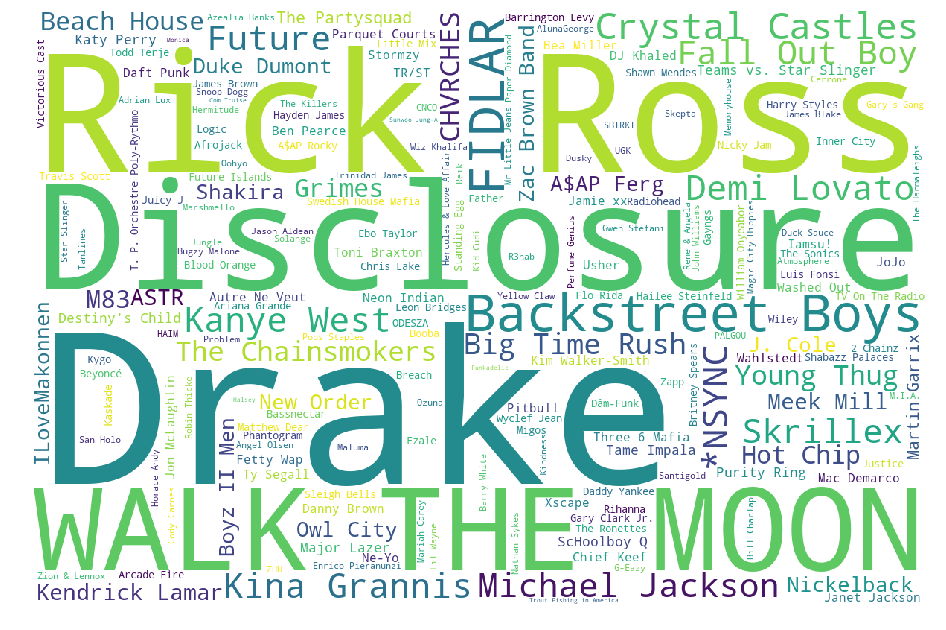

In [14]:
# word cloud sur les atistes les plus représentés dans la base de données.
nb_occ = pd.Series(a.toPandas()["count"].values,index=a.toPandas().artist).to_dict()
WC= WordCloud(background_color='white',margin=2,width=1200,height=800).generate_from_frequencies(nb_occ)
plt.figure(figsize=(16,12))
# on appelle l'objet wordcloud
plt.imshow(WC)
plt.axis("off")
plt.show()

### Répartition du nombre d'occurences des artistes

In [15]:
# on compte le nombre d'occurences
f = sdf_artist.groupBy('nb_occ').count()
nb_artists = sdf_artist.count()
g = f.withColumn("ratio",expr('count/1343'))
g.sort('nb_occ', ascending=False).show()

+------+-----+--------------------+
|nb_occ|count|               ratio|
+------+-----+--------------------+
|    16|    1|7.446016381236039E-4|
|    13|    1|7.446016381236039E-4|
|    12|    1|7.446016381236039E-4|
|    10|    2|0.001489203276247...|
|     9|    2|0.001489203276247...|
|     8|    9|0.006701414743112435|
|     7|    3|0.002233804914370...|
|     6|    7|0.005212211466865...|
|     5|   19|0.014147431124348473|
|     4|   28| 0.02084884586746091|
|     3|   58| 0.04318689501116903|
|     2|  210|  0.1563663440059568|
|     1| 1002|   0.746090841399851|
+------+-----+--------------------+



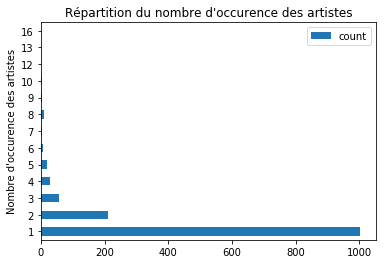

In [16]:
# Répartition du nombre d'occurences des artistes
df_artist = sdf_artist.groupBy('nb_occ').count().sort('nb_occ', ascending=True).toPandas()
df_artist .set_index('nb_occ', inplace = True) # passer les libellés en index, pour les afficher sur le graphe
ax = df_artist .plot(kind='barh', title = "Répartition du nombre d'occurence des artistes")
plt.ylabel("Nombre d'occurence des artistes"); 

La plupart des artistes apparaissent donc une, deux ou 3 fois dans les données. Seul 6% des artistes apparaissent plus de 3 fois. Le chanteur Drake est le plus fréquent et apparait 16 fois.

### Analyses des variables numériques

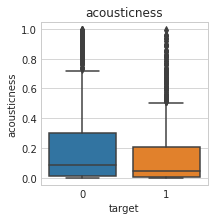

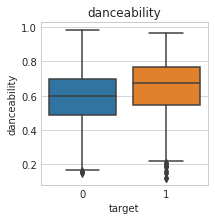

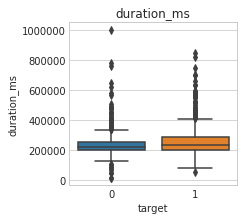

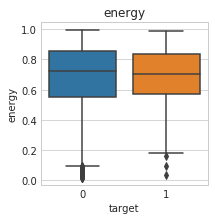

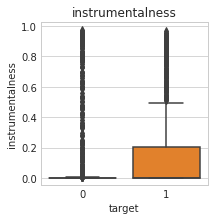

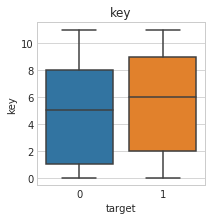

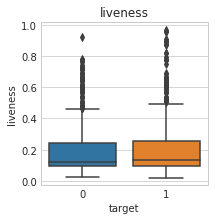

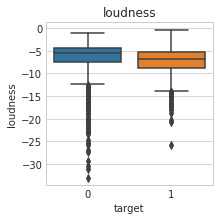

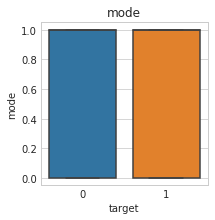

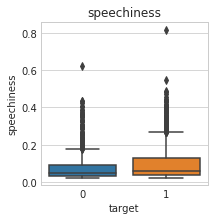

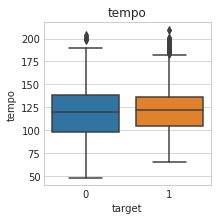

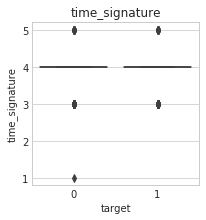

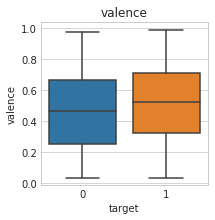

In [17]:
# on veut étudier les différences de distribution pour chaque variable, en fonction de la valeur de "target".
# Pour cela, on récupère un échantillon aléatoire et on trace les distributions pour cet échantillon.
df = sdf.sample(False, .9).toPandas()

sns.set_style("whitegrid")

for c in var_num:
    plt.figure(figsize=(3, 3))
    ax = sns.boxplot(x="target", y=c, data=df)
    ax.set_title(c)
plt.show()

A partir des boîtes à moustaches, on observe que le testeur aime :
* les chansons avec une acoustique plus faible, 
* les chansons sur lesquelles on peut danser,
* les chansons avec une instrumentalité plus élévée,
* les chansons avec une touche plus élevée,
* les chansons avec un volume plus faible,
* les chansons avec une valence plus forte.

### Analyses des variables catégorielles

In [15]:
# listes des variables catégorielles
var_cat=['time_signature','mode']

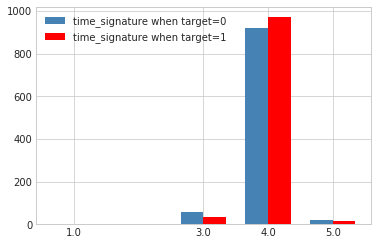

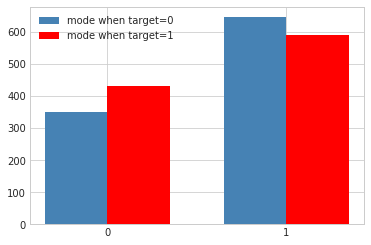

In [16]:
# On affiche les distributions des variables catégorielles en fonction de target.
time_signature_sdf = sdf.groupby('time_signature','target').count()
mode_sdf = sdf.groupby('mode','target').count()

time_signature_sdf_target0 = time_signature_sdf.filter(time_signature_sdf.target == 0 ).sort("time_signature")
time_signature_sdf_target1 = time_signature_sdf.filter(time_signature_sdf.target == 1 ).sort("time_signature")
mode_sdf_target0 = mode_sdf.filter(mode_sdf.target == 0 )
mode_sdf_target1 = mode_sdf.filter(mode_sdf.target == 1 )

time_signature_df_target0 = time_signature_sdf_target0.toPandas()
time_signature_df_target1 = time_signature_sdf_target1.toPandas()
mode_df_target0 = mode_sdf_target0.toPandas()
mode_df_target1 = mode_sdf_target1.toPandas()

bw = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(time_signature_df_target0['time_signature'], time_signature_df_target0['count'], bw, color='steelblue')
rects2 = ax.bar(time_signature_df_target1['time_signature']+bw, time_signature_df_target1['count'], bw, color='red')
ax.legend((rects1[0], rects2[0]), ('time_signature when target=0', 'time_signature when target=1'))
ax.set_xticks(time_signature_df_target0['time_signature'] + bw / 2)
ax.set_xticklabels(time_signature_df_target0['time_signature'])
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(mode_df_target0['mode'], mode_df_target0['count'], bw, color='steelblue')
rects2 = ax.bar(mode_df_target1['mode']+bw, mode_df_target1['count'], bw, color='red')
ax.legend((rects1[0], rects2[0]), ('mode when target=0', 'mode when target=1'))
ax.set_xticks(mode_df_target0['mode'] + bw / 2)
ax.set_xticklabels(mode_df_target0['mode'])
plt.show()

La variable signature temporelle comporte 4 modalités (1, 3, 4 et 5). La répartition est assez similaire pour target = 0 et target = 1. Donc cette variable devrait avoir peu d'impact dans la modélisation. 

La variable mode est une variable binaire. Le testeur préfère les chansons avec le mode 0.

## 3. Matrice des corrélations

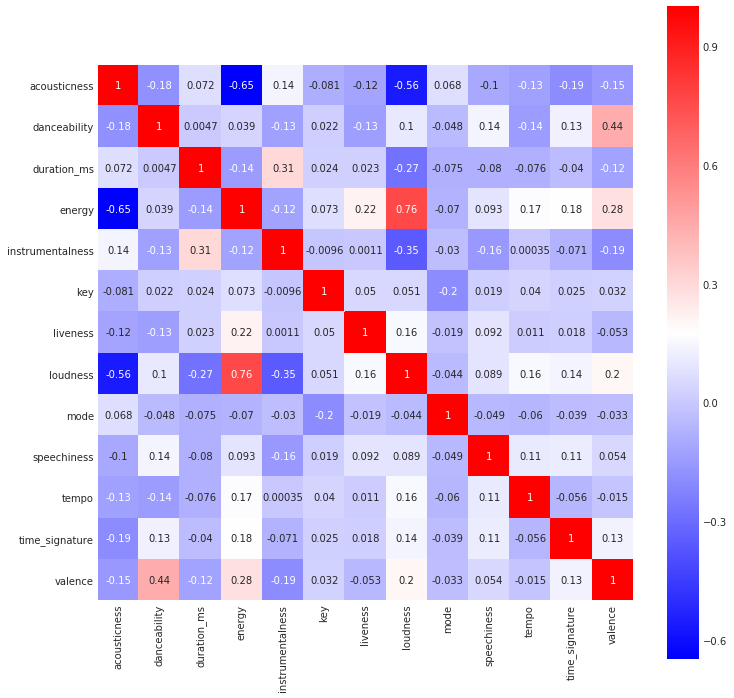

In [18]:
# Matrice des corrélations entre les variables
# on sélectionne les variables qui nous interessent
variables = sdf.select(var_num)
# VectorAssembler combine une liste de colonne en une seule colonne
assembler = VectorAssembler(inputCols=variables.columns,outputCol="features")
# on applique l'assembleur
assembled_variables = assembler.transform(variables)
# on calcule la corrélation
corr = Correlation.corr(assembled_variables, "features").head()
# on transforme l'élement en une matrice numpy
corr = corr[0].values.reshape((13,-1))
# on transforme en au format pandas
corr = pd.DataFrame(corr, columns=variables.columns, index=variables.columns) 
# on affiche le graphe
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr,cmap=plt.cm.bwr,square=True, ax=ax, annot=True);

D'après la matrice de corrélation, on observe que l'acoustique, le volume et l'énergie sont des variables très corrélées. La danceabilité et la valence sont également corrélées.

# Partie 2 : Analyse prédictive

Dans cette partie, nous cherchons à prédire si le testeur aime ou non cette chanson. Nous allons tester les modèles suivantes : une régression logistique, un arbre de décision et une forêt aléatoire. Pour chacun de ces modèles, nous testons d'abord le modèle avec les paramètres par défaut, puis nous cherchons les paramètres optimaux avec les librairies "ParamGridBuilder" et "CrossValidator".

In [19]:
var_num # liste des variables explicatives numériques 
var_cat.append("artist") # liste des variables explicatives catégorielles
for c in var_cat:
    if( c in var_num):
        var_num.remove(c)

In [20]:
# préparation des données
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

udIndexer = StringIndexer(inputCol="artist", outputCol="artist_idx")
sdf2 = udIndexer.fit(sdf).transform(sdf)

udEncoder = OneHotEncoder(inputCol="time_signature", outputCol="time_signature_enc")
sdf2 = udEncoder.transform(sdf2)

udEncoder = OneHotEncoder(inputCol="mode", outputCol="mode_enc")
sdf2 = udEncoder.transform(sdf2)

vecAssembler = VectorAssembler(inputCols=var_num, outputCol="features")
myPipeline = Pipeline(stages=[vecAssembler])

sdf2=myPipeline.fit(sdf2).transform(sdf2)

In [21]:
dd = sdf2.select("features").toPandas().head()
for x in dd.itertuples():
    print(x)

Pandas(Index=0, features=DenseVector([0.0102, 0.833, 204600.0, 0.434, 0.0219, 2.0, 0.165, -8.795, 0.431, 150.062, 0.286]))
Pandas(Index=1, features=DenseVector([0.199, 0.743, 326933.0, 0.359, 0.0061, 1.0, 0.137, -10.401, 0.0794, 160.083, 0.588]))
Pandas(Index=2, features=DenseVector([0.0344, 0.838, 185707.0, 0.412, 0.0002, 2.0, 0.159, -7.148, 0.289, 75.044, 0.173]))
Pandas(Index=3, features=DenseVector([0.604, 0.494, 199413.0, 0.338, 0.51, 5.0, 0.0922, -15.236, 0.0261, 86.468, 0.23]))
Pandas(Index=4, features=DenseVector([0.18, 0.678, 392893.0, 0.561, 0.512, 5.0, 0.439, -11.648, 0.0694, 174.004, 0.904]))


In [22]:
# On split le dataset en train et test
[train, test] = sdf2.randomSplit([0.8, 0.2], seed=1)
train.count()

1579

## 1. Régression logistique

In [23]:
from pyspark.ml.classification import LogisticRegression

# définition du modèle
lr = LogisticRegression(labelCol="target", featuresCol="features")

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-1.56303652069,1.51733184396,3.31490203285e-06,0.641875574065,1.32486894069,0.00792189950098,0.210960076586,-0.121197788941,4.26433377972,0.0034938293103,0.905690638587]
Intercept: -4.19669363233521


In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions.
predictions = lrModel.transform(test)

# Select example rows to display.
predictions.select("prediction", "target", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")
area = evaluator.evaluate(predictions)
print("ROC Error = %g " % (1.0 - area))

+----------+------+--------------------+
|prediction|target|            features|
+----------+------+--------------------+
|       1.0|     1|[0.18,0.678,39289...|
|       1.0|     1|[0.0572,0.525,358...|
|       1.0|     1|[0.314,0.713,1954...|
|       1.0|     1|[7.02E-4,0.854,24...|
|       0.0|     1|[0.279,0.512,2034...|
|       1.0|     1|[0.0358,0.959,213...|
|       0.0|     1|[0.297,0.722,1756...|
|       1.0|     1|[0.0128,0.747,213...|
|       1.0|     1|[4.1E-4,0.731,324...|
|       1.0|     1|[0.00243,0.621,37...|
+----------+------+--------------------+
only showing top 10 rows

ROC Error = 0.350398 


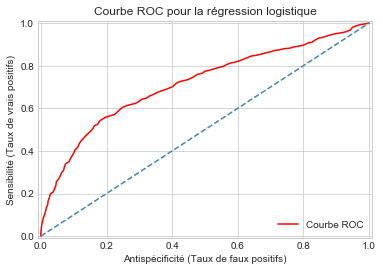

In [108]:
# on affiche la coube ROC
lg_roc = lrModel.summary.roc.toPandas()
lg_roc.plot(y='TPR',x='FPR', color='red', label='Courbe ROC')
plt.plot([0, 1], [0, 1], color='steelblue', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Antispécificité (Taux de faux positifs)')
plt.ylabel('Sensibilité (Taux de vrais positifs)')
plt.title('Courbe ROC pour la régression logistique')
plt.legend(loc="lower right")
plt.show()

In [48]:
%%time
# opitmisation des paramètres
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr = LogisticRegression(labelCol="target", featuresCol="features") 

# les paramètres par défaut de la régression logistique maxIter=100, regParam=0.0, elasticNetParam=0.0

# on définit les paramètres que l'on souhaite tester
grid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
             .addGrid(lr.maxIter, [10, 50, 80, 100, 120, 150])
             .build())

# on définit la mesure d'erreur
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",metricName= "areaUnderROC")

# Cross Validation
CrossVal = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

# On applique CrossValidation au modèle
cvModel = CrossVal.fit(train)

# On applique le modèle sur la base de test
predictions = cvModel.transform(test)

# On mesure l'AreaUnderROC(AUROC)
area = evaluator.evaluate(predictions)
print("ROC Error = %g " % (1.0 - area))

ROC Error = 0.350398 
CPU times: user 30.3 s, sys: 9.97 s, total: 40.2 s
Wall time: 16min 1s


In [49]:
# on récupère les paramètres du modèle optimal
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]

{Param(parent='LogisticRegression_47b88e956d08015b6288', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_47b88e956d08015b6288', name='maxIter', doc='max number of iterations (>= 0).'): 50,
 Param(parent='LogisticRegression_47b88e956d08015b6288', name='regParam', doc='regularization parameter (>= 0).'): 0.0}

Le modèle qui obtient les meilleurs résultats obtient les paramètres suivant : maxIter= 50, regParam=0.0, elasticNetParam=0.0. Le recherche des paramètres n'apportement pas énormément par rapport au paramètres par défaut.

## 2. Arbre de décision

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Train a DecisionTree model.
decisionTree = DecisionTreeClassifier(labelCol="target", featuresCol="features")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[decisionTree])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "target", "features").show(10)

# compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")
area = evaluator.evaluate(predictions)
print("ROC Error = %g " % (1.0 - area))

treeModel = model.stages[0]
# summary only
print(treeModel)

+----------+------+--------------------+
|prediction|target|            features|
+----------+------+--------------------+
|       1.0|     1|[0.18,0.678,39289...|
|       1.0|     1|[0.0572,0.525,358...|
|       1.0|     1|[0.314,0.713,1954...|
|       1.0|     1|[7.02E-4,0.854,24...|
|       0.0|     1|[0.279,0.512,2034...|
|       1.0|     1|[0.0358,0.959,213...|
|       0.0|     1|[0.297,0.722,1756...|
|       1.0|     1|[0.0128,0.747,213...|
|       1.0|     1|[4.1E-4,0.731,324...|
|       1.0|     1|[0.00243,0.621,37...|
+----------+------+--------------------+
only showing top 10 rows

ROC Error = 0.290608 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4db6924888f13508330a) of depth 5 with 51 nodes


In [45]:
%%time
# opitmisation des paramètres
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Train a DecisionTree model.
decisionTree = DecisionTreeClassifier(labelCol="target", featuresCol="features")

# les paramètres par défaut de l'arbre de décision est maxDepth = 5 et maxBins = 32

# on définit les paramètres que l'on souhaite tester
grid = (ParamGridBuilder()
             .addGrid(decisionTree.maxDepth , [3,4,5,6,7,8])
             .addGrid(decisionTree.maxBins, [5,10,15,20])
             .build())

# on définit la mesure d'erreur
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",metricName= "areaUnderROC")

# Cross Validation
CrossVal = CrossValidator(estimator=decisionTree , estimatorParamMaps=grid, evaluator=evaluator)

# On applique CrossValidation au modèle
cvModel = CrossVal.fit(train)

# On applique le modèle sur la base de test
predictions = cvModel.transform(test)

# On mesure l'AreaUnderROC(AUROC)
area = evaluator.evaluate(predictions)
print("ROC Error = %g " % (1.0 - area))

ROC Error = 0.277025 
CPU times: user 3.67 s, sys: 884 ms, total: 4.56 s
Wall time: 2min 7s


In [47]:
# on récupère les paramètres du modèle optimal
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]

{Param(parent='DecisionTreeClassifier_44b895d0a4f62fd9fae0', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
 Param(parent='DecisionTreeClassifier_44b895d0a4f62fd9fae0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4}

La recherche des paramètres améliore légérement le modèle passant d'une erreur de 0.290608 à 0.277025.  
Le modèle qui obtient les meilleurs résultats obtient les paramètres suivant : maxBins = 20 et maxDepth = 4.

## 3. Forêt aléatoire

In [52]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="target")
pipeline = Pipeline(stages=[rf])
rfmodel = pipeline.fit(train)
predictions = rfmodel.transform(test)
predictions.select("prediction", "target", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")
area = evaluator.evaluate(predictions)
print("ROC Error = %g " % (1.0 - area))

rfModel = rfmodel.stages[0]
print(rfModel)

+----------+------+--------------------+
|prediction|target|            features|
+----------+------+--------------------+
|       1.0|     1|[0.18,0.678,39289...|
|       1.0|     1|[0.0572,0.525,358...|
|       1.0|     1|[0.314,0.713,1954...|
|       1.0|     1|[7.02E-4,0.854,24...|
|       0.0|     1|[0.279,0.512,2034...|
|       0.0|     1|[0.0358,0.959,213...|
|       0.0|     1|[0.297,0.722,1756...|
|       0.0|     1|[0.0128,0.747,213...|
|       1.0|     1|[4.1E-4,0.731,324...|
|       1.0|     1|[0.00243,0.621,37...|
+----------+------+--------------------+
only showing top 10 rows

ROC Error = 0.280789 
RandomForestClassificationModel (uid=RandomForestClassifier_4c03a747758de54021a5) with 20 trees


In [54]:
%%time
# opitmisation des paramètres
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Train a RandomForest model.
rf = RandomForestClassifier(featuresCol="features", labelCol="target")

# les paramètres par défaut de l'arbre de décision est maxDepth = 5, maxBins = 32 et numTrees = 20

# on définit les paramètres que l'on souhaite tester
grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth , [3,4,5,6,7,8])
             .addGrid(rf.numTrees, [10,15,20,25,30])
             .addGrid(rf.maxBins, [10,15,20,25,30])
             .build())

# on définit la mesure d'erreur
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",metricName= "areaUnderROC")

# Cross Validation
CrossVal = CrossValidator(estimator=rf , estimatorParamMaps=grid, evaluator=evaluator)

# On applique CrossValidation au modèle
cvModel = CrossVal.fit(train)

# On applique le modèle sur la base de test
predictions = cvModel.transform(test)

# On mesure l'AreaUnderROC(AUROC)
area = evaluator.evaluate(predictions)
print("ROC Error = %g " % (1.0 - area))

ROC Error = 0.267049 
CPU times: user 22.8 s, sys: 8.04 s, total: 30.9 s
Wall time: 15min 8s


In [55]:
# on récupère les paramètres du modèle optimal
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]

{Param(parent='RandomForestClassifier_4ac9904257349a054c03', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
 Param(parent='RandomForestClassifier_4ac9904257349a054c03', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 7,
 Param(parent='RandomForestClassifier_4ac9904257349a054c03', name='numTrees', doc='Number of trees to train (>= 1).'): 30}

La recherche des paramètres améliore légérement le modèle passant d'une erreur de 0.280789 à 0.267049. 
Le modèle qui obtient les meilleurs résultats obtient les paramètres suivant : maxBins = 20, maxDepth = 7 et numTrees = 30.

## Conclusion

Nous avons essayé de construire un classifieur qui pourrait prédire si l'utilisateur aime ou non une chanson. Pour cela, nous avons testé 3 modèles : Regression Logistic, Arbre de décision et Forêt aléatoire. Nous obtenons des résultats assez proches pour ces 3 modèles. Nous avons utilisé comme mesure d'évaluatuion de notre modèle ROC Error = 1 - AUC(Aire sous la courbe ROC). Plus AUC tend vers 1, meilleur est notre modèle. Donc plus ROC Error tend vers 0, meilleur est notre modèle. Le modèle qui obtient les meilleurs résultats est la Forêt aléatoire avec une un ROC Error de 0.267049.